<a href="https://colab.research.google.com/github/datxander/Back-to-basics/blob/main/Linear_regression%20-%20Ocean%20temperatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORT KAGGLE SECRETS

from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [6]:
! pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"denny2383","key":"2afb68157d21cc23424b0bc3bcbe9e0c"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [7]:
# CODE TO IMPORT DATA FROM KAGGLE


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'calcofi:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2190%2F3685%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240417%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240417T185340Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc8d650ed31d49813d977cc1f84b2319878aca68f259d2230b39cff84278a8c76b787a8038fb58b5c6e19bf6320d237ba4c0118aa569e25cd9bd9902164377435353f129339e137680f3ace135dd3c18aebc1e26ced1eb71983766da4083007cab7b08c8805d97d3aba8f2ff5ee89b1701d8d109a1e3b25b8e2ceca4df8d3e204a2b7753c473df8e97055b3caa02048299387082543be1c8483074537d1868fa8c87d5f854529cc73d41a6e494b86fd0780d93c709480df507fa70dae92f15433a5238400ea65bb8d881448de141260168d985a6012e6f07074e292199f7b3f17ef3c4056d28a9d476d26b34a5025137a9a8d204410d5a1b52a63e9fbf76e4ee9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 52872856 bytes downloaded
Downloaded and uncompressed: calcofi
Data source import complete.


In [8]:
# IMPORT LIBRARIES AND DATASETS

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import operator

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/calcofi/bottle.csv
/kaggle/input/calcofi/cast.csv


In [9]:
# READ DATASETS

bottle = pd.read_csv("../input/calcofi/bottle.csv")
bottle.head(10)

<ipython-input-9-e77b6739d704>:3: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  bottle = pd.read_csv("../input/calcofi/bottle.csv")


,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,6,054.0 056.0,19-4903CR-HY-060-0930-05400560-0030A-7,30,10.45,33.431,NaN,25.651,NaN,...,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,7,054.0 056.0,19-4903CR-HY-060-0930-05400560-0039A-3,39,10.45,33.440,NaN,25.658,NaN,...,NaN,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,8,054.0 056.0,19-4903CR-HY-060-0930-05400560-0050A-7,50,10.24,33.424,NaN,25.682,NaN,...,NaN,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,9,054.0 056.0,19-4903CR-HY-060-0930-05400560-0058A-3,58,10.06,33.420,NaN,25.710,NaN,...,NaN,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,10,054.0 056.0,19-4903CR-HY-060-0930-05400560-0075A-7,75,9.86,33.494,NaN,25.801,NaN,...,NaN,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
bottle.describe()

,Cst_Cnt,Btl_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,BtlNum,...,R_CHLA,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1
count,864863.000000,864863.000000,864863.000000,853900.000000,817509.000000,696201.000000,812174.000000,661274.000000,661268.000000,118667.000000,...,225276.000000,225275.000000,864863.000000,122006.000000,1999.000000,224.000000,2084.000000,234.000000,10.000000,84.000000
mean,17138.790958,432432.000000,226.831951,10.799677,33.840350,3.392468,25.819394,57.103779,148.808694,10.497426,...,0.450225,0.198599,228.395694,162.071521,2153.239714,2168.148330,2256.055845,2278.858803,7.948570,7.910983
std,10240.949817,249664.587269,316.050259,4.243825,0.461843,2.073256,1.167787,37.094137,90.187533,6.189688,...,1.208566,0.376539,319.456731,85.722796,112.995202,154.852332,34.844435,58.496495,0.021216,0.077666
min,1.000000,1.000000,0.000000,1.440000,28.431000,-0.010000,20.934000,-0.100000,-0.434900,0.000000,...,-0.010000,-3.890000,0.000000,0.000000,1948.850000,1969.440000,2181.570000,2198.150000,7.923100,7.618300
25%,8269.000000,216216.500000,46.000000,7.680000,33.488000,1.360000,24.965000,21.100000,60.915470,5.000000,...,0.050000,0.050000,46.000000,200.000000,2028.330000,2008.977500,2230.322500,2229.062500,7.931475,7.898675
50%,16848.000000,432432.000000,125.000000,10.060000,33.863000,3.440000,25.996000,54.400000,151.064150,10.000000,...,0.160000,0.110000,126.000000,206.000000,2170.640000,2265.885000,2244.325000,2247.505000,7.946650,7.928850
75%,26557.000000,648647.500000,300.000000,13.880000,34.196900,5.500000,26.646000,97.600000,240.379600,16.000000,...,0.390000,0.230000,302.000000,214.000000,2253.810000,2315.525000,2278.505000,2316.452500,7.963300,7.955100
max,34404.000000,864863.000000,5351.000000,31.140000,37.034000,11.130000,250.784000,214.100000,485.701800,25.000000,...,66.110000,65.300000,5458.000000,424.000000,2367.800000,2364.420000,2434.900000,2437.000000,7.988300,8.047700


In [14]:
# linear regression with one variable

# filter dataset for the target and 1 feature only

bottle_df = bottle[['T_degC', 'Salnty']]
bottle_df = bottle_df[:][:500]
bottle_df.columns = ['Temperature', 'Salinity']
bottle_df.head()


,Temperature,Salinity
0,10.50,33.440
1,10.46,33.440
2,10.46,33.437
3,10.45,33.420
4,10.45,33.421


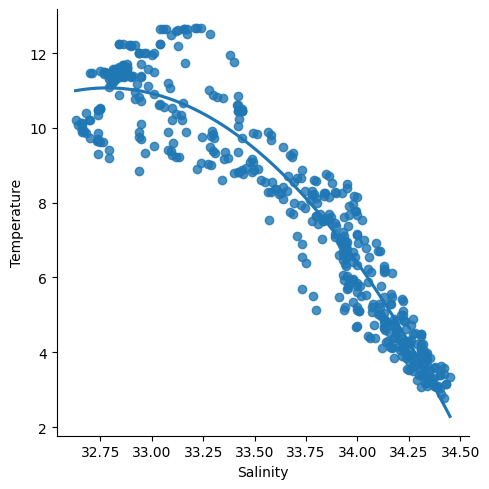

In [15]:
# EDA - Scatterplot

sns.lmplot(x = "Salinity", y = "Temperature", data = bottle_df, order = 2, ci = None)

In [16]:
# Null value check

bottle_df.isnull().sum()

Temperature    1
Salinity       6
dtype: int64

In [17]:
# Null value replacement

bottle_df.fillna(method = 'ffill', inplace = True)


In [19]:
#Reshaping the data into X and Y datasets for regression

X = np.array(bottle_df['Salinity']).reshape(-1,1)
y = np.array(bottle_df['Temperature']).reshape(-1,1)



In [20]:
# Train / test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 23)

In [23]:
# Linear regression

# Model fitting

from sklearn.linear_model import LinearRegression

lin_df = LinearRegression()
lin_df.fit(X_train, y_train)



LinearRegression()

In [24]:
# Model predictions
y_pred = lin_df.predict(X_test)
accuracy = lin_df.score(X_test, y_test)
print("Model Accuracy Score: " + "{:.1%}".format(accuracy))

Model Accuracy Score: 82.9%


In [25]:
# Regression model metrics - MSE / R2

from sklearn.metrics import mean_squared_error, r2_score

print("R2 score :" + "{:.3}".format(r2_score(y_test, y_pred)) );




R2 score :0.829


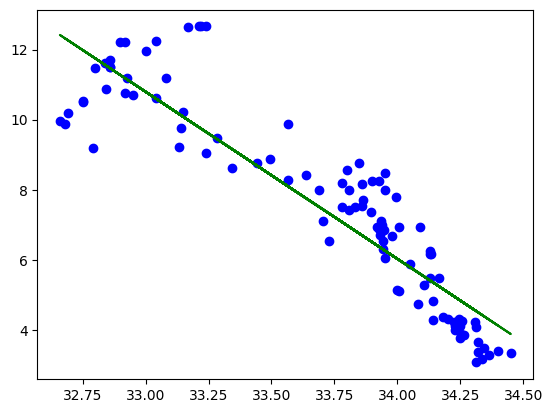

In [26]:
# Model diagram

plt.scatter(X_test, y_test, color = 'b')
plt.plot(X_test, y_pred, color = 'g')
plt.show()